In [1]:
import tensorflow as tf

import numpy as np
import pandas as pd
import pickle
import os
import rcca
from PIL import Image

from scipy.stats import pearsonr
import scipy
from sklearn import cross_decomposition
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

import keras
from keras import callbacks
from keras.losses import sparse_categorical_crossentropy
from keras.models import load_model

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import matplotlib as mpl
from matplotlib.legend_handler import HandlerLine2D
mpl.rcParams['text.usetex'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# helper functions

In [2]:
def load_mnist():

    mnist = tf.keras.datasets.mnist

    (x_train, y_train),(x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    
    return x_train, x_test, y_train, y_test

In [3]:
def save_and_convert(image_name):
    image = Image.open(image_name)
    image = image.convert('CMYK')
    image_name = image_name.split(".")[0] + "CMYK.tif"
    image.save(image_name)

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict

In [5]:
def load_cifar():
    
    path = "/home/thomas/Documents/cifar-10-python/cifar-10-batches-py"
    
    list_y = []
    list_x = []
    for file in os.listdir(path):
        if "data" in file:
            full_path = path + "/" + file
            dict_batch = unpickle(full_path)
            list_y.append(dict_batch[b'labels'])
            list_x.append(dict_batch[b'data'])

    y_train = np.asarray([val for sublist in list_y for val in sublist])
    x_train = np.asarray([val for sublist in list_x for val in sublist])

    test_path = path + "/" + "test_batch"
    dict_test = unpickle(test_path)
    y_test, x_test = np.asarray(dict_test[b'labels']), np.asarray(dict_test[b'data'])
    
    x_train, x_test = x_train/255.0, x_test/255.0
    
    return x_train, x_test, y_train, y_test

In [6]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [7]:
def one_hot(array):
    enc = OneHotEncoder(categories='auto')
    array = np.reshape(array, (array.shape[0],1))
    enc.fit(array)
    array_hot = enc.transform(array)
    
    return array_hot

In [8]:
def bartlett_test(list_corr, cc_i, cc_number, n=10000):
    m = cc_number
    
    first_term = -(n-cc_i+1-0.5*(2*m+1))
    first_term_sum = 0
    for index in range(cc_i):
        first_term_sum += 1/(list_corr[index]**2)
    first_term += first_term_sum
    
    second_term = 1
    for index in range(cc_i+1, len(list_corr)):
        second_term *= (1-list_corr[index]**2)
    second_term = np.log(second_term)
    
    result = first_term * second_term
    p_value = 1-scipy.stats.chi2.cdf(result, (m-cc_i)**2)

    # the null is that the canonical correlation coefficient is 0
    reject_null = True
    if p_value > 0.05:
        reject_null = False
    
    return reject_null

In [9]:
data = "cifar10"

In [10]:
# for mnist

if data == "mnist":
    x_train, x_test, y_train, y_test = load_mnist()

    x_train = np.reshape(x_train, (x_train.shape[0], 784))
    x_test = np.reshape(x_test, (x_test.shape[0], 784))

    one_hot_y_test = one_hot(y_test)
    one_hot_y_train = one_hot(y_train)

elif data == "cifar10":
    # for cifar

    x_train, x_test, y_train, y_test = load_cifar()

    one_hot_y_test = one_hot(y_test)
    one_hot_y_train = one_hot(y_train)
    
else:
    raise ValueError('the string for the dataset is wrong')


# matching neurons (Algorithm 1)

In [11]:
def get_intermediate_layers(data_x, list_weights):
    
    num_hidden_layers = int((len(list_weights)-1)/2)
    list_hidden_representation = []
    count = 0
    for layer in range(num_hidden_layers):
        
        if layer == 0:
            hidden_layer = np.matmul(data_x, list_weights[count]) + list_weights[count+1]
            hidden_layer[hidden_layer < 0] = 0
        else:
            hidden_layer = np.matmul(hidden_layer, list_weights[count]) + list_weights[count+1]
            hidden_layer[hidden_layer < 0] = 0
        list_hidden_representation.append(hidden_layer)
        count += 2
    
    return list_hidden_representation

In [12]:
def get_nn_pairs(nn_1_id, nn_2_id, data="mnist"):
    
    if data == "mnist":
    
        nn_1 = load_model('mnist_weights/mnist_weights_lr_0.001/' + 'weights_nn_' + str(nn_1_id) + '.h5')
        weights_nn_one = nn_1.get_weights()

        nn_2 = load_model('mnist_weights/mnist_weights_lr_0.001/' + 'weights_nn_' + str(nn_2_id) + '.h5')
        weights_nn_two = nn_2.get_weights()
        
    elif data == "cifar10":
        
        nn_1 = load_model('cifar10_weights/' + 'weights_nn_' + str(nn_1_id) + '.h5')
        weights_nn_one = nn_1.get_weights()

        nn_2 = load_model('cifar10_weights/' + 'weights_nn_' + str(nn_2_id) + '.h5')
        weights_nn_two = nn_2.get_weights()
        
    else:
        raise ValueError('the string for the dataset is wrong')
    
    return weights_nn_one, weights_nn_two

In [13]:
def meta_cc(original_variables_cc, num_cc_to_keep):
    
    y_weights = np.asarray([original_variables_cc[index][1] for index in range(len(original_variables_cc))])
    x_weights = np.asarray([original_variables_cc[index][0] for index in range(len(original_variables_cc))])
    cc_rank_x = np.zeros((x_weights.shape[0], x_weights.shape[1]))
    cc_rank_y = np.zeros((y_weights.shape[0], y_weights.shape[1]))

    list_neurons_x = []
    list_neurons_y = []
    
    my_range = list(range(x_weights.shape[0]))[:num_cc_to_keep]
    counter = 0
    for index in my_range:
        indice_array = np.arange(0, y_weights.shape[1], 1)
        tuple_coeffs_x = list(zip(x_weights[index], indice_array))
        tuple_coeffs_y = list(zip(y_weights[index], indice_array))
        tuple_coeffs_x.sort()
        tuple_coeffs_y.sort()
        rank_array = np.abs([val[0] for val in tuple_coeffs_x])+np.abs([val[0] for val in tuple_coeffs_y])

        rank_array = list(zip(rank_array, indice_array))
        rank_array.sort()
        rank_array = [val[1] for val in rank_array]
        rank_array_tuple = list(zip(rank_array, indice_array))
        rank_array_tuple.sort()

        count = 1
        
        if (np.sum(x_weights[index] == 0) != x_weights.shape[0]) and (np.sum(y_weights[index] == 0) != y_weights.shape[0]):

            while len(list_neurons_x) < (counter+1) and len(list_neurons_y) < (counter+1):

                best_indice = rank_array[-count]
                best_neuron_x = np.asarray([val[1] for val in tuple_coeffs_x])[best_indice]
                best_neuron_y = np.asarray([val[1] for val in tuple_coeffs_y])[best_indice]

                if (best_neuron_x in list_neurons_x) or (best_neuron_y in list_neurons_y):
                    count += 1
                else:
                    list_neurons_x.append(best_neuron_x)
                    list_neurons_y.append(best_neuron_y)

                    cc_rank_x[counter, best_neuron_x] = counter+1
                    cc_rank_y[counter, best_neuron_y] = counter+1

                if data == "mnist":
                    max_num = 513
                else:
                    max_num = 101

                if count == max_num:
                    break
        
            counter += 1
        
    overall_cc_a = np.sum(cc_rank_x, axis=0)
    overall_cc_b = np.sum(cc_rank_y, axis=0)
    
    tuple_cc = (overall_cc_a, overall_cc_b)
    
    return tuple_cc
    

In [14]:
# obtain the cca canonical components + the loaded models

def get_canonical_components(relu_original_one, relu_original_two, num_cca_components=10, svd=False, num_pc=10, non_regularized=True):
    
    scaler = StandardScaler()
    relu_layer_one_original = scaler.fit_transform(relu_original_one)
    relu_layer_two_original = scaler.fit_transform(relu_original_two)

    if svd:
        U_first, S_first, V_first = np.linalg.svd(relu_layer_one_original)
        U_second, S_second, V_second = np.linalg.svd(relu_layer_two_original)
        relu_layer_one = np.dot(U_first[:,:num_pc], S_first[:num_pc]*np.eye(num_pc))
        relu_layer_two = np.dot(U_second[:,:num_pc], S_second[:num_pc]*np.eye(num_pc))
        
    # CCA on pc matrices keep the same number of components as number of classes
    
    # non regularized
    if non_regularized:
        cca = cross_decomposition.CCA(n_components=num_cca_components, scale=False, max_iter=2000, tol=1e-06, copy=True)
        cca.fit(relu_layer_one, relu_layer_two)
        U, V = cca.transform(relu_layer_one, relu_layer_two)

        list_corr = []
        for cc in range(cca.n_components):
            corr = np.corrcoef(U[:,cc], V[:,cc])[0,1]
            list_corr.append(corr)
        print(np.sum(np.array(list_corr)>0.7))

        x_weights = cca.x_weights_
        y_weights = cca.y_weights_
        
    # regularized
    else:
        cca_rcca = rcca.CCA(reg=0.1, numCC=num_cca_components)
        cca_rcca.train([relu_layer_one_original, relu_layer_two_original])
        list_corr = cca_rcca.cancorrs

        x_weights = cca_rcca.ws[0]
        y_weights = cca_rcca.ws[1]

    original_variables_cc = []
    if svd:
        for index in range(num_cca_components):

            # get the PCs we want for first nn
            pc_array = V_first[:num_pc,:]
            pc_new_array = pc_array*np.reshape(x_weights[:,index], (x_weights.shape[0],1))
            original_coeff_first = np.sum(pc_new_array, axis=0)

            # same thing for the second neural network
            pc_array_second = V_second[:num_pc,:]
            pc_new_array_second = pc_array_second*np.reshape(y_weights[:,index], (y_weights.shape[0],1))
            original_coeff_second = np.sum(pc_new_array_second, axis=0)

            original_variables_cc.append((original_coeff_first, original_coeff_second))
            
    else:
        for index in range(num_cca_components):
            original_variables_cc.append((x_weights[:,index], y_weights[:,index]))
    
    original_variables_cc = meta_cc(original_variables_cc, num_cca_components)
        
    return original_variables_cc

In [15]:
# cross correlation function
def get_corr(relu_original_one, relu_original_two):
    
    axis_number = 0
    semi_matching = False
    n = relu_original_one.shape[1]
    list_neurons_x = []
    list_neurons_y = []
    
    scaler = StandardScaler()# Fit your data on the scaler object
    relu_layer_one = scaler.fit_transform(relu_original_one)
    relu_layer_two = scaler.fit_transform(relu_original_two)

    corr_matrix_nn = np.empty((n,n))

    for i in range(n):
        for j in range(n):
            corr = np.corrcoef(relu_layer_one[:,i], relu_layer_two[:,j])[0,1]
            corr_matrix_nn[i,j] = corr

    corr_matrix_nn[np.isnan(corr_matrix_nn)] = -1
    
    #argmax_columns = np.argmax(corr_matrix_nn, axis=axis_number)
    argmax_columns = np.flip(np.argsort(corr_matrix_nn, axis=axis_number), axis=axis_number)
    dead_neurons = np.sum(corr_matrix_nn, axis=axis_number) == n*(-1) # these are neurons that always output 0 (dead relu)
    for index in range(n):
        if dead_neurons[index] == False:
            if semi_matching:
                if axis_number == 0:
                    list_neurons_y.append(index)
                    list_neurons_x.append(argmax_columns[0,index])
                elif axis_number == 1:
                    list_neurons_x.append(index)
                    list_neurons_y.append(argmax_columns[index,0])
                    
            elif semi_matching == False:
                
            # do not allow same matching
                for count in range(n):

                    if axis_number == 0:
                        if argmax_columns[count,index] not in list_neurons_x:
                            list_neurons_y.append(index)
                            list_neurons_x.append(argmax_columns[count,index])
                            break
                    elif axis_number == 1:
                        if argmax_columns[index,count] not in list_neurons_y:
                            list_neurons_x.append(index)
                            list_neurons_y.append(argmax_columns[index,count])
                            break
    
    # randomly pair the unpaired neurons
    for index in range(n):
        if index not in list_neurons_x and len(list_neurons_x) < n:
            list_neurons_x.append(index)
        if index not in list_neurons_y and len(list_neurons_y) < n:
            list_neurons_y.append(index)
    
    return list_neurons_x, list_neurons_y

# permuting neurons to funtionally align networks (Algorithm 2)

In [16]:
def compute_loss(list_weights, data_x, data_y):
    
    num_hidden_layers = int((len(list_weights)-1)/2)
    count = 0
    for layer in range(num_hidden_layers):
        
        if layer == 0:
            second_relu_layer = np.matmul(data_x, list_weights[count]) + list_weights[count+1]
            second_relu_layer[second_relu_layer < 0] = 0
        else:
            second_relu_layer = np.matmul(second_relu_layer, list_weights[count]) + list_weights[count+1]
            second_relu_layer[second_relu_layer < 0] = 0
        count += 2
    
    result = np.matmul(second_relu_layer, list_weights[len(list_weights)-1])
    result = softmax(result)
    
    loss = log_loss(data_y, result)
    res_hot = one_hot(np.argmax(result, axis=1))
    categories_to_keep = np.unique(np.argmax(result, axis=1))
    data_y = data_y[:,categories_to_keep]
  
    if len(categories_to_keep) == 1:
        data_y = np.reshape(data_y, (data_y.shape[0],))
        res_hot = np.reshape(res_hot, (res_hot.shape[0],))
        
    accuracy = accuracy_score(data_y, res_hot)
    
    return loss, accuracy

In [17]:
# reoder the neurons according to the value of their canonical weights

def reorder_canonical(canonical_coeffs):
    indice_array = np.arange(0, canonical_coeffs.shape[0], 1)
    canonical_coeffs = list(zip(canonical_coeffs, indice_array))
    canonical_coeffs.sort()
    
    canonical_coeffs = [tuple_value[1] for tuple_value in canonical_coeffs]
    
    return canonical_coeffs
    

In [18]:
def order_weights(nn_weights_list, list_indices_hidden):
    
    count = 0
    depth = count * 2
    for layer in range(len(list_indices_hidden)):
        for index in range(3):
            if index == 0:
                nn_weights_list[index+depth] = nn_weights_list[index+depth][:,list_indices_hidden[layer]] # order columns for weights
            elif index == 1:
                nn_weights_list[index+depth] = nn_weights_list[index+depth][list_indices_hidden[layer]] # order columns for bias
            elif index == 2:
                nn_weights_list[index+depth] = nn_weights_list[index+depth][list_indices_hidden[layer],:] # order rows
        
        count += 1
        depth = count * 2
    
    nn_weights_list = np.asarray(nn_weights_list)
    
    return nn_weights_list
    

In [19]:
def return_ordered_weights_and_indices(original_variables_cc, weights_nn_one, weights_nn_two):
    # get the order of the canonical coefficient and get the indices of the ordered hidden layer

    number_hidden_layers = len(original_variables_cc_list)
    
    list_ordered_indices_one = []
    list_ordered_indices_two = []
    for index in range(number_hidden_layers):
        
        ordered_original_coeff_first = reorder_canonical(original_variables_cc_list[index][0])
        ordered_original_coeff_second = reorder_canonical(original_variables_cc_list[index][1])
        
        list_ordered_indices_one.append(ordered_original_coeff_first)
        list_ordered_indices_two.append(ordered_original_coeff_second)
    
    # order the weight matrices       
    list_ordered_weights_one = order_weights(weights_nn_one, list_ordered_indices_one)
    list_ordered_weights_two = order_weights(weights_nn_two, list_ordered_indices_two)
        
    
    return list_ordered_weights_one, list_ordered_weights_two

# linear path between the two trained networks (untouched)

In [20]:
def get_min_untouched_nn(data_x, data_y, weights_nn_one, weights_nn_two):
    
    loss_list = []
    half_fitness = 0
    my_range = np.arange(-0.5, 1.52, 1/50)
    my_range[25] = 0
    my_range[50]= 0.5
    for t in my_range:
        list_weights = []
        for index in range(len(weights_nn_one)):
            averaged_weights = (1-t)*weights_nn_one[index] + t*weights_nn_two[index]
            list_weights.append(averaged_weights)
        loss, accuracy = compute_loss(list_weights, data_x, data_y)
        loss_list.append((loss, accuracy))
        
        if t == 0.5:
            half_fitness = loss
    
    return loss_list, half_fitness

In [21]:
# list_best_t = []
# my_range = np.arange(-0.5, 1.52, 1/50)
# my_range[25] = 0
# my_range[50]= 0.5
    
# for i in [0]:
#     for j in [1]:
#         if j != i:
#             print("Computing for the NN pair (" + str(i) + "," + str(j) + ")")
                
#             weights_nn_one, weights_nn_two = get_nn_pairs(i,j, data="mnist")

#             loss_list_train, half_fitness_train = get_min_untouched_nn(x_train, one_hot_y_train, weights_nn_one, weights_nn_two)
#             loss_list_test, half_fitness_test = get_min_untouched_nn(x_test, one_hot_y_test, weights_nn_one, weights_nn_two)
#             best_t_value = my_range[int(np.argmin(loss_list_test)/2)]
#             print(min(loss_list_test), best_t_value)

#             # compute the loss at the mimimum points (t = 1 and t = 0)
#             print(compute_loss(weights_nn_one, x_test, one_hot_y_test))
#             print(compute_loss(weights_nn_two, x_test, one_hot_y_test))
#             list_best_t.append(best_t_value)
                

# Arithmetic Crossover

In [34]:
def save_weights_nn_pairs(ist_ordered_weights_one, ist_ordered_weights_two, i):

    t = 0.5
    list_weights = []
    for index in range(len(list_ordered_weights_one)):
        averaged_weights = list_ordered_weights_one[index]*(1-t) + list_ordered_weights_two[index]*t
        list_weights.append(averaged_weights)

    pickle.dump(list_weights, open('ES_mnist/weight_t=05_nn=' + str(i) + '.pickle', 'wb'))
    pickle.dump(list_ordered_weights_one, open('ES_mnist/weight_t=0_nn=' + str(i) + '.pickle', 'wb'))
    pickle.dump(list_ordered_weights_two, open('ES_mnist/weight_t=1_nn=' + str(i) + '.pickle', 'wb'))

In [35]:
svd = True
cca = False # if true we use cca to match neurons, otherwise we use pariwise cross-correlation

In [36]:
my_range = list(np.arange(-0.5, 1.52, 1/50))
my_range[25] = 0
my_range[50]= 0.5
count_better_loss_half = 0
count_better_loss_min = 0
cc_number = [256]
if data == "cifar10":
    cc_number = [100, 100, 100]
    

num_pairs = 1
list_val_plot = []
list_minima_random = []
list_half_cca, list_half_random = [], []
for i in range(2):
    if i % 2 == 0:
        j = i + 1
        half_fitness_cca = 0
        list_val_plot.append([])
        print("Computing for the NN pair (" + str(i) + "," + str(j) + ")")
                
        weights_nn_one, weights_nn_two = get_nn_pairs(i,j, data=data)
                
        list_hidden_representation_one = get_intermediate_layers(x_test, weights_nn_one)
        list_hidden_representation_two = get_intermediate_layers(x_test, weights_nn_two)

        original_variables_cc_list = []
        list_ordered_indices_one = []
        list_ordered_indices_two = []
        for index in range(len(list_hidden_representation_one)): 
            hidden_layer_one = list_hidden_representation_one[index]
            hidden_layer_two = list_hidden_representation_two[index]
            if cca:
                if svd:
                    original_variables_cc = get_canonical_components(hidden_layer_one, hidden_layer_two, cc_number[index], svd, cc_number[index], non_regularized=True)
                else:
                    original_variables_cc = get_canonical_components(hidden_layer_one, hidden_layer_two, 100, svd, 100, non_regularized=True)
                original_variables_cc_list.append(original_variables_cc)
            else:
                indices_one, indices_two = get_corr(hidden_layer_one, hidden_layer_two)
                list_ordered_indices_one.append(indices_one)
                list_ordered_indices_two.append(indices_two)
                
        if cca:
            weights_nn_one_copy = weights_nn_one[:]
            weights_nn_two_copy = weights_nn_two[:]
            list_ordered_weights_one, list_ordered_weights_two = return_ordered_weights_and_indices(original_variables_cc_list, weights_nn_one_copy, weights_nn_two_copy)
        else:
            # order the weight matrices       
            weights_nn_one_copy = weights_nn_one[:]
            weights_nn_two_copy = weights_nn_two[:]
            list_ordered_weights_one = order_weights(weights_nn_one_copy, list_ordered_indices_one)
            list_ordered_weights_two = order_weights(weights_nn_two_copy, list_ordered_indices_two)
                    
        loss_list, half_fitness_random = get_min_untouched_nn(x_test, one_hot_y_test, weights_nn_one, weights_nn_two)
        list_val_plot[num_pairs-1].append(loss_list)
        list_minima_random.append(min(loss_list))
        best_t_value = my_range[int(np.argmin([loss_list[index][0] for index in range(len(loss_list))]))]
            
        loss_list_cc1 = []
        for t in my_range:
            list_weights = []
            for index in range(len(weights_nn_one)):
                averaged_weights = list_ordered_weights_one[index]*(1-t) + list_ordered_weights_two[index]*t
                list_weights.append(averaged_weights)
                        
            loss, accuracy = compute_loss(list_weights, x_test, one_hot_y_test)
            loss_list_cc1.append((loss, accuracy))
            if t == 0.5:
                half_fitness_cca = loss
        list_val_plot[num_pairs-1].append(loss_list_cc1)

        min_cca = min([loss_list_cc1[index][0] for index in range(len(loss_list_cc1))])
        list_half_cca.append(half_fitness_cca)
        list_half_random.append(half_fitness_random)
                    
        if half_fitness_cca < half_fitness_random:
            count_better_loss_half += 1
        
        print(str(min(loss_list)), best_t_value)
        print(min_cca)
        print("loss for safe crossover at t=0.5: " + str(half_fitness_cca) + " loss for random at t=0.5 " + str(half_fitness_random))
        print("The ratio of better solutions is at t=0.5 is " + str(count_better_loss_half) + "/" + str(num_pairs))
            
        save_weights_nn_pairs(list_ordered_weights_one, list_ordered_weights_two, i)
        
        num_pairs += 1


Computing for the NN pair (0,1)
(1.5968366351385745, 0.4271) 0.9800000000000013
1.5979084781830906
loss for safe crossover at t=0.5: 2.1022966035091604 loss for random at t=0.5 2.310764380240558
The ratio of better solutions is at t=0.5 is 1/1


# Correlation of neurons for mnist (Result Section)

In [24]:
order_nn_1 = reorder_canonical(original_variables_cc_list[0][0])

In [25]:
order_nn_2 = reorder_canonical(original_variables_cc_list[0][1])

In [28]:
corr_matrix_nn_unordered = np.zeros((512, 512))

In [29]:
i_index = 0
for i in range(512):
    j_index = 0
    for j in range(512):
        corr = np.corrcoef(list_hidden_representation_one[0][:,i], list_hidden_representation_two[0][:,j])[0,1]
        corr_matrix_nn_unordered[i,j] = corr

In [ ]:
corr_matrix_nn_unordered[np.isnan(corr_matrix_nn_unordered)] = -1

In [35]:
corr_list = []
for index in range(512):
    corr_list.append(np.max(corr_matrix_nn_unordered[index,:]))

In [37]:
corr_list.sort()

In [41]:
np.sum(np.array(corr_list) > 0.7)

204

In [98]:
# this is for ordered neurons
i_index = 0
for i in order_nn_1:
    j_index = 0
    for j in order_nn_2:
        corr = np.corrcoef(list_hidden_representation_one[0][:,i], list_hidden_representation_two[0][:,j])[0,1]
        corr_matrix_nn_ordered[i_index,j_index] = corr
        j_index += 1
    i_index += 1

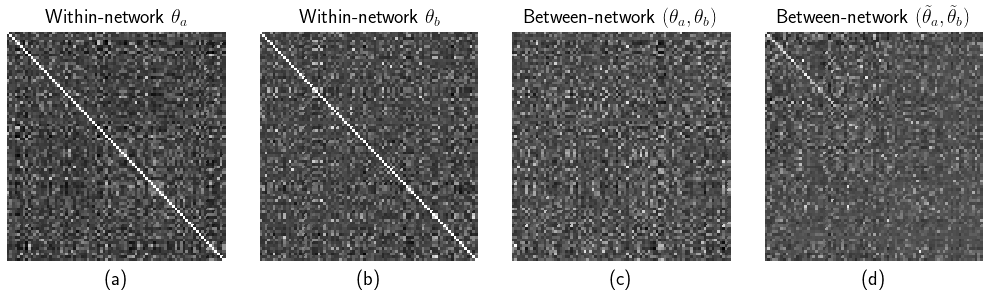

In [158]:
f, axes = plt.subplots(1, 4, figsize=(14,4.2))

ax = sns.heatmap(corr_matrix_nn_1[412:494,412:494], ax=axes[0], cmap="gist_gray", cbar=False)
axes[0].set_xlabel("(a)", size=20)
axes[0].set_title("Within-network " + r'$\theta_a$', size=20)
axes[0].set_yticklabels('')
axes[0].set_xticklabels('')
axes[0].tick_params(axis='both', which='both', length=0)

ax = sns.heatmap(corr_matrix_nn_2[412:494,412:494], ax=axes[1], cmap="gist_gray", cbar=False)
axes[1].set_xlabel("(b)", size=20)
axes[1].set_title("Within-network " + r'$\theta_b$', size=20)
axes[1].set_yticklabels('')
axes[1].set_xticklabels('')
axes[1].tick_params(axis='both', which='both', length=0)

ax = sns.heatmap(corr_matrix_nn_unordered[412:494,412:494], ax=axes[2], cmap="gist_gray", cbar=False)
axes[2].set_xlabel("(c)", size=20)
axes[2].set_title("Between-network " + r'$(\theta_a, \theta_b)$', size=20)
axes[2].set_yticklabels('')
axes[2].set_xticklabels('')
axes[2].tick_params(axis='both', which='both', length=0)

ax = sns.heatmap(corr_matrix_nn_ordered[412:494,412:494], ax=axes[3], cmap="gist_gray", cbar=False)
axes[3].set_xlabel("(d)", size=20)
axes[3].set_title("Between-network " + r'$(\tilde{\theta}_a, \tilde{\theta}_b)$', size=20)
axes[3].set_yticklabels('')
axes[3].set_xticklabels('')
axes[3].tick_params(axis='both', which='both', length=0)

image_name = "pairwise_corr.pdf"
plt.tight_layout(pad=1)
plt.savefig(image_name, dpi=600, bbox_inches = 'tight')

# plots for proportion and arithmetic crossover (Result section)

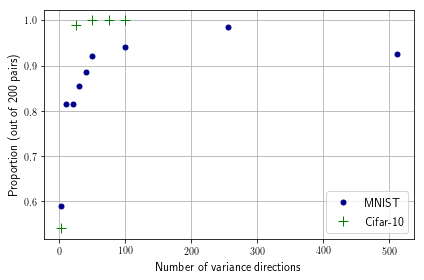

In [95]:
x_array = np.array([2, 10, 20, 30, 40, 50, 100, 256, 512])
y_array = np.array([0.590, 0.815, 0.815, 0.855, 0.885, 0.920, 0.94, 0.985, 0.925])
plt.plot()
plt.plot(x_array, y_array, marker="o", linestyle="", markersize=5, color="darkblue")
plt.plot(np.array([2, 25, 50, 75, 100]), np.array([0.54, 0.99, 1.0, 1.0, 1.0]), markersize=10, linestyle="", marker="+", color="green")
plt.grid(True)
plt.legend(["MNIST", "Cifar-10"], loc="lower right", fontsize=12)
plt.ylabel("Proportion (out of 200 pairs)", fontsize=12)
plt.xlabel("Number of variance directions", fontsize=12)
plt.savefig("proportion.pdf", dpi=600, bbox_inches = 'tight', pad_inches=0)
plt.tight_layout()

In [30]:
list_random_shuffle = []
list_pc_shuffle = []

for index in range(100):
    list_random_shuffle.append(list_val_plot[index][0])
    list_pc_shuffle.append(list_val_plot[index][1])

mean_random, std_random = np.mean(np.asarray(list_random_shuffle), axis=0), np.std(np.asarray(list_random_shuffle), axis=0)
mean_pc, std_pc = np.mean(np.asarray(list_pc_shuffle), axis=0), np.std(np.asarray(list_pc_shuffle), axis=0)


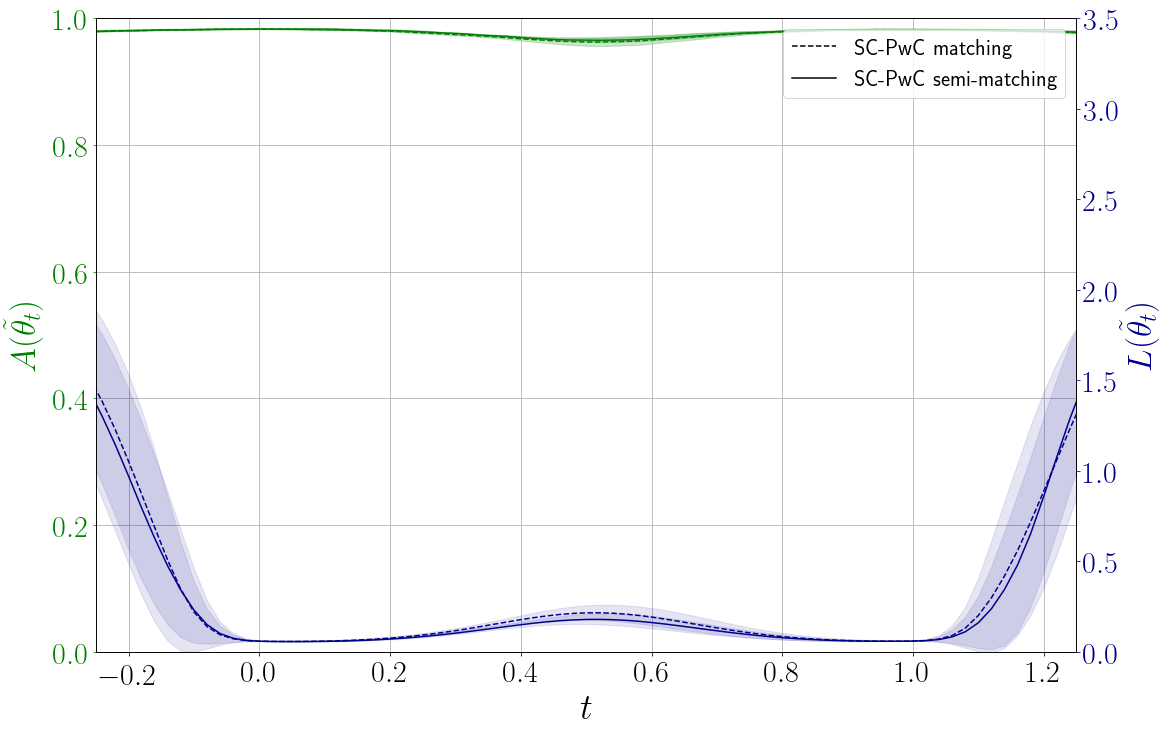

In [31]:
fig, host = plt.subplots(figsize=(16,10))
plt.grid(True)
par1 = host.twinx()

color1 = "darkblue"
color2 = "green"

host.set_xlim(-0.25, 1.25)
host.set_ylim(0, 1.0)
par1.set_ylim(0,3.5)
host.set_xlabel(r'$t$', fontsize=36)
par1.set_ylabel(r'$L(\tilde{\theta_t})$', fontsize=34, color=color1)
host.set_ylabel(r'$A(\tilde{\theta_t})$', fontsize=34, color=color2, labelpad=15)
host.yaxis.set_label_coords(-0.05,0.5)


host.tick_params(axis='y', colors=color2, labelsize=30)
par1.tick_params(axis='y', colors=color1, labelsize=30)
host.tick_params(axis='x', colors="black", labelsize=30)

line1 = Line2D(my_range, mean_random[:,0], color="black", alpha=1.0, linestyle='dashed')
line2 = Line2D(my_range, mean_pc[:,1], color="black", alpha=1.0)
plt.legend((line1, line2), ('SC-PwC matching','SC-PwC semi-matching'), fontsize=22, loc="top right")

par1.plot(my_range, mean_random[:,0], color=color1, alpha=1.0, linestyle='dashed')
host.plot(my_range, mean_pc[:,1], color=color2, alpha=1.0)
par1.plot(my_range, mean_pc[:,0], color=color1, alpha=1.0)
host.plot(my_range, mean_random[:,1], color=color2, alpha=1.0, linestyle='dashed')


par1.fill_between(my_range, mean_random[:,0]+std_random[:,0], mean_random[:,0]-std_random[:,0], color=color1, alpha=0.1)
par1.fill_between(my_range, mean_pc[:,0]+std_pc[:,0], mean_pc[:,0]-std_pc[:,0], color=color1, alpha=0.1)
host.fill_between(my_range, mean_random[:,1]+std_random[:,1], mean_random[:,1]-std_random[:,1], color=color2, alpha=0.2)
host.fill_between(my_range, mean_pc[:,1]+std_pc[:,1], mean_pc[:,1]-std_pc[:,1], color=color2, alpha=0.2)
plt.tight_layout(pad=0.05)
#plt.savefig("matching_vs_semimatching_cifar.pdf", dpi=600, bbox_inches = 'tight')

### experimentation on synthetic dataset (not in paper)

In [20]:
x = np.random.randn(10000,100)
y = np.random.randn(10000,100)

for index in range(x.shape[0]):
    col_num = np.random.randint(0,10)
#     x[index, col_num] = np.random.randn(1)+10
#     y[index, col_num] = np.random.randn(1)+10
    
    #break the datasets: x_col_1 is (0.2*y_col_11+0.8*y_col_12)
    if col_num == 0:
        x[index, col_num] = np.random.randn(1)+10
        y[index, 10] = np.random.randn(1)+(0.8*10)
        y[index, 11] = np.random.randn(1)+(0.2*10)
        
    #break the datasets: x_col_2 is (0.5*y_col_13+0.5*y_col_14)
    elif col_num == 1:
        x[index, col_num] = np.random.randn(1)+10
        y[index, 12] = np.random.randn(1)+(0.8*10)
        y[index, 13] = np.random.randn(1)+(0.2*10)
        
    else:
        x[index, col_num] = np.random.randn(1)+10
        y[index, col_num] = np.random.randn(1)+10
        

scaler = StandardScaler()# Fit your data on the scaler object
scaled_x = scaler.fit_transform(x)
scaled_y = scaler.fit_transform(y)

In [21]:
cca = cross_decomposition.CCA(n_components=100, scale=True, max_iter=2000, tol=1e-06, copy=True)
cca.fit(scaled_x, scaled_y)

U, V = cca.transform(scaled_x, scaled_y)

In [22]:
list_corr = []
for cc in range(cca.n_components):
    corr = np.corrcoef(U[:,cc], V[:,cc])[0,1]
    print(corr)
    list_corr.append(corr)

0.9144388170012121
0.9111532985631181
0.9117849476455779
0.9101258525141761
0.9083754428899871
0.9059257497374523
0.9053575525499836
0.8970946949221806
0.8953551224339117
0.1855646375347092
0.1766311171483661
0.17267796561423546
0.1713826484411514
0.16725136728899836
0.1611666889773426
0.15753575283275362
0.15605529383935202
0.15444724779949925
0.1496146725350099
0.14782425973735702
0.14598838743339862
0.14285862544237699
0.1397629141885892
0.1396622508452443
0.1372388743433897
0.13172628346277107
0.12999050022177103
0.1284222986222819
0.12663847024257233
0.12295592310238371
0.12240015987123923
0.11727287496796861
0.11666498487791334
0.11537362992300375
0.11412907443859652
0.11193321070523736
0.10953029796339772
0.10880918631307306
0.108276669150913
0.10432790035071578
0.10250512626868327
0.09977022065064825
0.09959889111927293
0.0957042792128151
0.09491169973149728
0.09381730529289639
0.09162111017376724
0.0893468096546576
0.08876854096422329
0.08668230786260275
0.08556271792649511
0.

In [23]:
list_corr_stand = ((list_corr-np.min(list_corr))/(np.max(list_corr)-np.min(list_corr)))

coeff = np.sum(np.abs(np.matmul(x, cca.x_weights_)), axis=0)
coeff = coeff - min(coeff)
coeff /= np.sum(coeff)
#coeff = ((coeff-np.min(coeff))/(np.max(coeff)-np.min(coeff)))

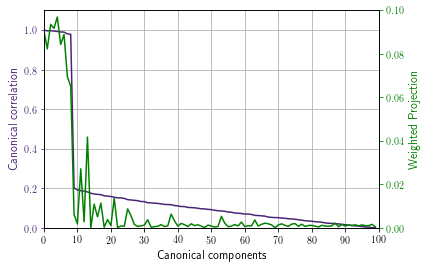

In [24]:
fig, host = plt.subplots()
plt.grid(True)

par1 = host.twinx()

host.set_xlim(0, len(list_corr_stand))
host.set_ylim(0, 1.1)
par1.set_ylim(0, 0.1)
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])

host.set_xlabel("Canonical components", fontsize=12)
host.set_ylabel("Canonical correlation", fontsize=12)
par1.set_ylabel("Weighted Projection", fontsize=12)

color1 = plt.cm.viridis(0.1)
color2 = "green"

host.tick_params(axis='y', colors=color1)
par1.tick_params(axis='y', colors=color2)

p1, = host.plot(list(range(len(list_corr_stand))), list_corr_stand, color=color1,label="Canonical Correlation")
p2, = par1.plot(list(range(len(list_corr_stand))), coeff, color=color2, label="Weighted Projection")

#lns = [p1, p2]
#host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

image_name = "canonical_corr.pdf"
plt.savefig(image_name, dpi=600, bbox_inches = 'tight', pad_inches=0)
#save_and_convert(image_name)

plt.show()

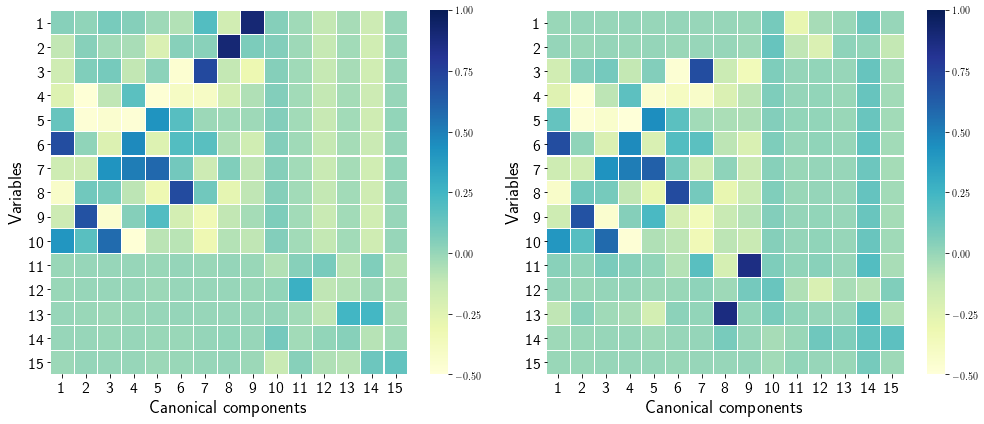

In [25]:
f, axes = plt.subplots(1, 2, figsize=(14,6))

ax = sns.heatmap(cca.x_weights_[:15,:15], linewidth=0.01, cmap="YlGnBu", ax=axes[0], vmin=-0.5, vmax=1)
axes[0].set_xlabel("Canonical components", size=18)
axes[0].set_ylabel("Variables", size=18)
#axes[0].set_title("Canonical coefficients for X", size=16)
axes[0].set_xticklabels('')
axes[0].set_xticks([x+0.5 for x in range(15)], minor=True)
axes[0].set_xticklabels(list(range(1,16)), minor=True, fontdict={"fontsize":16})
axes[0].set_yticklabels('')
axes[0].set_yticks([x+0.5 for x in range(15)], minor=True)
axes[0].set_yticklabels(list(range(1,16)), minor=True, fontdict={"fontsize":16})

ax = sns.heatmap(cca.y_weights_[:15,:15], linewidth=0.01, cmap="YlGnBu", ax=axes[1], vmin=-0.5, vmax=1)
axes[1].set_xlabel("Canonical components", size=18)
axes[1].set_ylabel("Variables", size=18)
#axes[1].set_title("Canonical coefficients for Y", size=16)
axes[1].set_xticklabels('')
axes[1].set_xticks([x+0.5 for x in range(15)], minor=True)
axes[1].set_xticklabels(list(range(1,16)), minor=True, fontdict={"fontsize":16})
axes[1].set_yticklabels('')
axes[1].set_yticks([x+0.5 for x in range(15)], minor=True)
axes[1].set_yticklabels(list(range(1,16)), minor=True, fontdict={"fontsize":16})


image_name = "corry.pdf"
plt.savefig(image_name, dpi=600, bbox_inches = 'tight', pad_inches=0)
#save_and_convert(image_name)
plt.tight_layout()

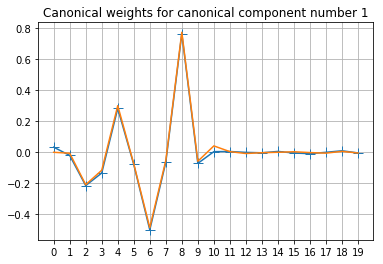

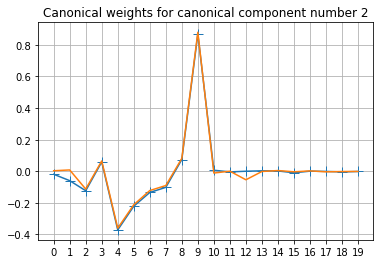

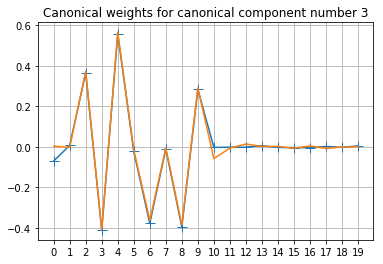

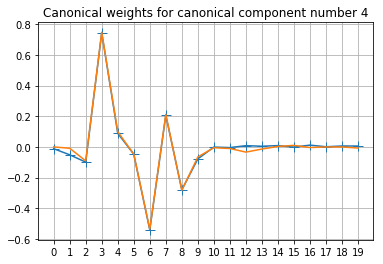

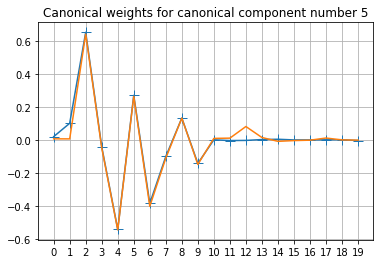

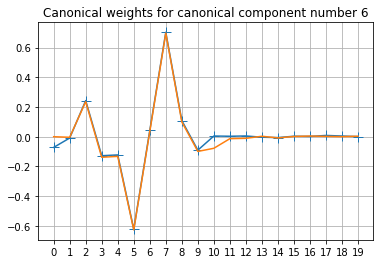

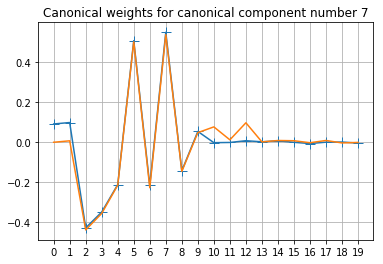

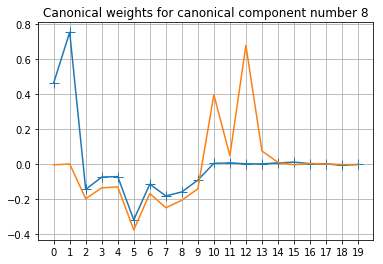

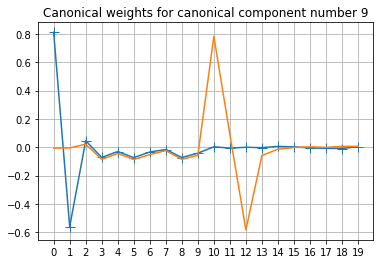

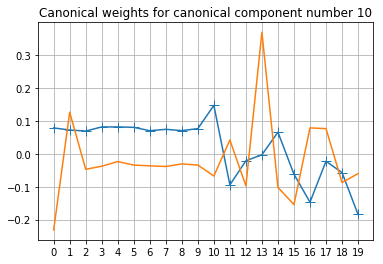

In [26]:
for index in range(10):   
    plt.plot()
    plt.title("Canonical weights for canonical component number " + str(index+1))
    plt.xticks(np.arange(0,20))
    plt.plot(cca.x_weights_[:20,index], marker="+", markersize=10)
    plt.plot(cca.y_weights_[:20,index])
    plt.grid()
    plt.show()